# Cain's Jawbone

[introduction: murder mystery blabla, took this opportunity to try out graph algorithms to help in this puzzle,...]

## A Book as a Graph?

In order to use graph algorithm we first need to convert the book into a graph. Since we do not know the actual ordering of the pages we can consider a fully connected graph, where each node represents a page, with the edges weighted by how similar the two pages are. One way to measure this similarity is to vectorize the pages by calculating the frequencies of how often each word in the book appears on the page. These vectors can then be compared using the cosine similarity $S_C(x, y) = \frac{\langle x, y \rangle}{\|x\| \|y\|}$. Since in this case we always deal with positive frequencies $S_C \in [0, 1]$.

In [21]:
from tqdm import trange

from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

import matplotlib as mpl
from matplotlib import pyplot as plt

from netgraph import Graph
import networkx as nx
import numpy as np

from nltk import word_tokenize, pos_tag, download
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.cluster import SpectralClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# download relevant nltk datasets
datasets = ["wordnet", "omw-1.4", "punkt", "averaged_perceptron_tagger", "stopwords"]
for dataset in datasets:
    download(dataset)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Before we can calculate the word frequencies we need to do some data preparation. The following is a very standard routine for natural language processing, where we tokenize the text, remove special characters and single letters, lemmatize (i.e. use the standard form of the word) and remove so called stop words, that is words that do not carry relevant information like "is", "the" and "and".

In [2]:
stop_words = set(stopwords.words("english"))

def to_wordnet(tag: str) -> str | None:
    """Converts between position tags and wordnet tags for lemmatization"""
    match tag[0]:
        case "J":
            return wordnet.ADJ
        case "R":
            return wordnet.ADV
        case "N":
            return wordnet.NOUN
        case "V":
            return wordnet.VERB
        case _:
            return None


def preprocess(text: str) -> str:
    """Tokenizes and lemmatizes the text"""
    tokens = [token for token in word_tokenize(text.lower())]
    cleaned = [token for token in tokens if len(token) > 1 and token[0].isalnum() and token[-1].isalnum()]
    tagged = [(word, to_wordnet(tag)) for word, tag in pos_tag(cleaned) if len(word) > 1]
    lemmatizer = WordNetLemmatizer()
    lemmatized = [
        lemmatizer.lemmatize(word, pos=tag) for (word, tag) in tagged if tag is not None
    ]
    words = [word for word in lemmatized if word not in stop_words]
    return " ".join(words)

In [3]:
# load Cain's Jawbone book
with open("books/Cain's Jawbone.txt", "r", encoding="utf-8") as book:
    pages = book.read().split("\n\n")

data = [preprocess(page) for page in pages]

In [4]:
# vectorize tokens to frequencies
vectorizer = TfidfVectorizer(use_idf=False)
freqs = vectorizer.fit_transform(data)

# calculate cosine similarities between pages
num_pages = len(data)
weights = np.zeros((num_pages, num_pages))
for i, j in np.ndindex(weights.shape):
    weights[i, j] = cosine_similarity(freqs.getrow(i), freqs.getrow(j)).flatten()[0]

# generate fully connected, weighted graph
graph = nx.complete_graph(num_pages)
for i, j in graph.edges:
    graph.edges[i, j]["weight"] = weights[i, j]

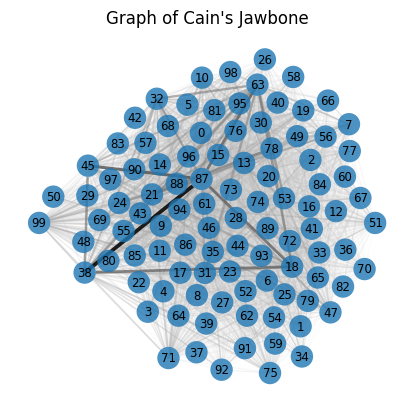

In [35]:
stats = np.array([graph.edges[edge]["weight"] for edge in graph.edges])

edge_dict = {
    (i, j): graph.edges[(i, j)]["weight"] / stats.max() for (i, j) in graph.edges
}

Graph(
    graph,
    node_layout="spring",
    node_layout_kwargs=dict(edge_weights=edge_dict),
    node_color="C0",
    node_size=3,
    node_alpha=0.8,
    node_edge_width=0,
    edge_alpha=edge_dict,
    edge_width=edge_dict,
    node_labels=True,
)
plt.title("Graph of Cain's Jawbone")
plt.show()

Below you can see the distribution of the weights in the graph:

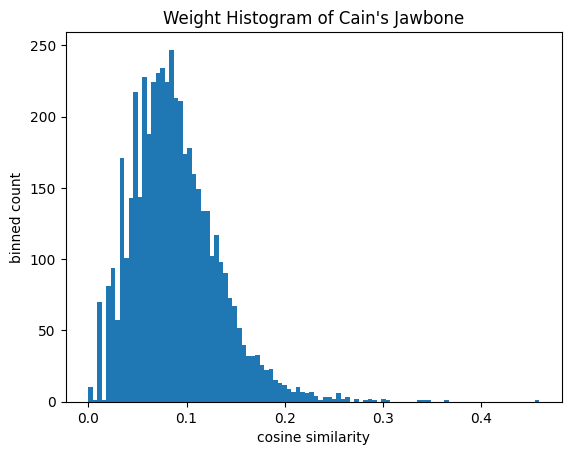

minimum 0.000
average 0.089 +- 0.0439
maximum 0.459


In [36]:
plt.hist(stats, bins=100)
plt.xlabel("cosine similarity")
plt.ylabel("binned count")
plt.title("Weight Histogram of Cain's Jawbone")
plt.show()

print(f"minimum {stats.min():5.3f}")
print(f"average {stats.mean():5.3f} +- {stats.std():5.3}")
print(f"maximum {stats.max():5.3f}")

## Recover the Reading Sequence?

So what can we now do with this graph. Since one of the problems is to find the correct reading sequence of the 100 pages we could try to find a path through our graph that maximizes similarity. There are two problems with this approach though. Firstly since the graph is fully connected there are $100! \approx 10^{158}$ possible paths this is very computationally expensive and we would need some more heuristics to solve this. Secondly going from one page to another that are very similar might not be the correct sequence since there can be (and in fact there are) multiple narratives that follow each other without possibly being very similar.

We still tried to come up with a combination of a graph neural network and a recurrent neural network that would be trained on actual books and retrieve a reading sequence of Cain's Jawbone. But this turned out to be very complicated and too ambitious for this project. You can see our experiments on our [GNN notebook on GitHub](https://github.com/maxstolly/Graph-Algorithms-Project/blob/main/gnn.ipynb) that were inspired by the approaches of [Attention, Learn to Solve Routing Problems!](https://arxiv.org/abs/1803.08475) and [Learning the Travelling Salesperson Problem Requires Rethinking Generalization](https://arxiv.org/abs/2006.07054), that try to solve the traveling salesperson problem using GNNs and reinforcement learning.

## Different Approach: Clustering!

Since the problem of finding a reading sequence was too complex for this project we settled on trying to find the 6 murdered and their 6 murderers. It is theorized by the community of people who try to solve this puzzle, that there are 6 dinstinct narratives surrounding each murder. Thus we could use clustering / community detection to find the pages that correspond to these narratives.

### Spectral Clustering

[explain algorithm]

In [9]:
# TODO: implement spectral clustering ???
def spectral_clustering(
    graph: nx.Graph, num_clusters: int, weight: str = "weight", seed: int | None = None
):
    adj_matrix = nx.adjacency_matrix(graph, weight=weight).todense()
    clusterer = SpectralClustering(
        n_clusters=num_clusters,
        affinity="precomputed",
        assign_labels="kmeans",
        random_state=seed,
    )
    return clusterer.fit_predict(adj_matrix)

### Louvain Algorithm

[explain algorithm]

In [7]:
# TODO: implement the louvain algorithm ???
louvain_algorithm = nx.community.louvain_communities

Unlike spectral clustering the Louvain algorithm does not take the number of desired clusters as input but rather finds its own number of clusters through optimizing modularity. So in order to find our 6 narratives we have to tweak the resolution parameter to nudge the algorithm towards our desired number of clusters. Since there is some randomness involved in the algorithm we show the statistics of the number of found clusters from 100 runs below.

In [8]:
resolution = 1.05

runs = []
for seed in range(100):
    communities = louvain_algorithm(graph, resolution=resolution, seed=seed)
    runs.append(len(communities))
runs = np.array(runs)

print("number of communities detected by the Louvain algorithm")
print(f"minimum {runs.min()}")
print(f"average {runs.mean():.2f} +- {runs.std():.2f}")
print(f"maximum {runs.max()}")

number of communities
minimum 5
average 6.08 +- 0.67
maximum 8


## Comparison

How do we know compare the two algorithms? We basically have two options: calculating some sort of measure of "goodness" of the clusters and using knowledge from the book to examine if the clusters actually correspond to narratives.

### Quantitative Analysis

What could be a measure of "goodness" of the clusters? [explain coherence]

Since there is some randomness involved in the algorithms we will compare the coherence score statistics of 100 runs of each algorithm.

In [10]:
texts = [page.split() for page in data]
book_dictionary = Dictionary(vectorizer.inverse_transform(freqs))

def coherence(groups: list[set[int]]) -> float:
    """Returns coherence measure for given groupings"""

    topics = []
    for group in groups:
        words = set()
        for node in group:
            words.update(data[node].split())
        topics.append(list(words))

    model = CoherenceModel(
        topics=topics,
        texts=texts,
        dictionary=book_dictionary,
        coherence="c_v",
    )

    return model.get_coherence()

In [11]:
resolution = 1.05
num_clusters = 6
num_runs = 100
min_length = 5
seed_mod = 0

scores_louvain = []
scores_spectral = []
for seed in trange(num_runs):
    groups_louvain = []
    while len(groups_louvain) != num_clusters or np.any(
        [len(group) < min_length for group in groups_louvain]
    ):
        groups_louvain = louvain_algorithm(
            graph, resolution=resolution, seed=seed + seed_mod
        )
        seed_mod += 1
    scores_louvain.append(coherence(groups_louvain))
    if scores_louvain[-1] == max(scores_louvain):
        best_louvain = groups_louvain

    labels = spectral_clustering(graph, num_clusters, seed=seed)
    groups_spectral = [
        set([node for node in graph if labels[node] == i]) for i in range(num_clusters)
    ]
    scores_spectral.append(coherence(groups_spectral))
    if scores_spectral[-1] == max(scores_spectral):
        best_spectral = groups_spectral

scores_louvain = np.array(scores_louvain)
scores_spectral = np.array(scores_spectral)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [32:03<00:00, 19.23s/it]


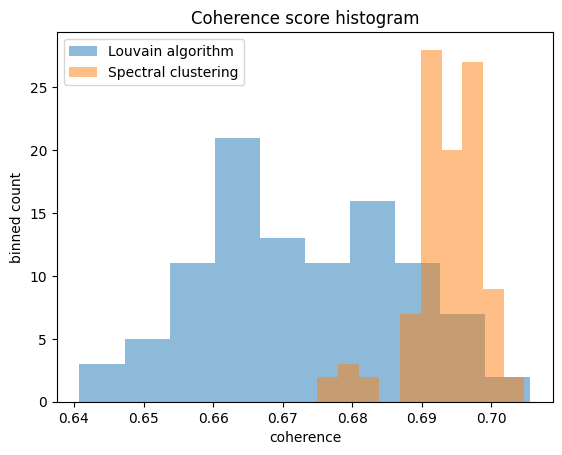

           min    mean +- std     max  
louvain  [0.641, 0.673 +- 0.014, 0.706]
spectral [0.675, 0.693 +- 0.005, 0.705]


In [12]:
bins = 10
plt.hist(scores_louvain, bins=bins, alpha=0.5, label="Louvain algorithm")
plt.hist(scores_spectral, bins=bins, alpha=0.5, label="Spectral clustering")
plt.xlabel("coherence")
plt.ylabel("binned count")
plt.title("Coherence score histogram")
plt.legend()
plt.show()

print("           min    mean +- std     max  ")
print(f"louvain  [{scores_louvain.min():.3f}, {scores_louvain.mean():.3f} +- {scores_louvain.std():.3f}, {scores_louvain.max():.3f}]")
print(f"spectral [{scores_spectral.min():.3f}, {scores_spectral.mean():.3f} +- {scores_spectral.std():.3f}, {scores_spectral.max():.3f}]")

### Qualitative Analysis

Since the book is very complicated and difficult to read we will omit an actual qualitative analysis using the domain knowledge but rather just take a quick look at the best clusters produced by the two algorithms and see if and how they differ.

In [13]:
def plot_groups(
    graph: nx.Graph, groups: list[set[int]], title: str | None = None
) -> None:
    """Plot the communities of a graph."""
    groups_dict = {
        node: i for (i, group) in enumerate(groups) for node in group
    }
    colors = mpl.colormaps["tab10"].colors[: len(groups)]
    node_color = {node: colors[i] for node, i in groups_dict.items()}
    max_weight = np.array([graph.edges[edge]["weight"] for edge in graph.edges]).max()
    edge_dict = {(i, j): graph.edges[(i, j)]["weight"] / max_weight for (i, j) in graph.edges}

    Graph(
        graph,
        node_color=node_color,
        node_edge_width=0,
        edge_alpha=edge_dict,
        edge_width=edge_dict,
        node_layout="community",
        node_layout_kwargs=dict(node_to_community=groups_dict),
        node_labels=True,
    )
    if title is not None:
        plt.title(title)
    plt.show()

c:\Users\maxst\Repos\Graph-Algorithms-Project\.venv\Lib\site-packages\netgraph\_node_layout.py:1023: RuntimeWarning: invalid value encountered in divide
  directions = deltas / magnitudes[:, np.newaxis]
c:\Users\maxst\Repos\Graph-Algorithms-Project\.venv\Lib\site-packages\netgraph\_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


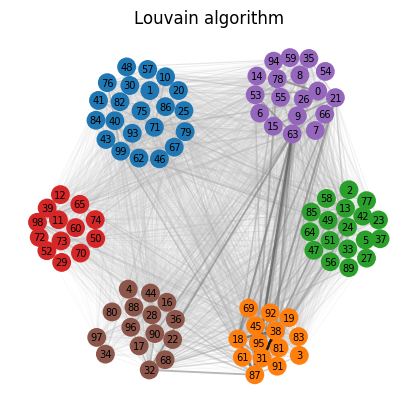

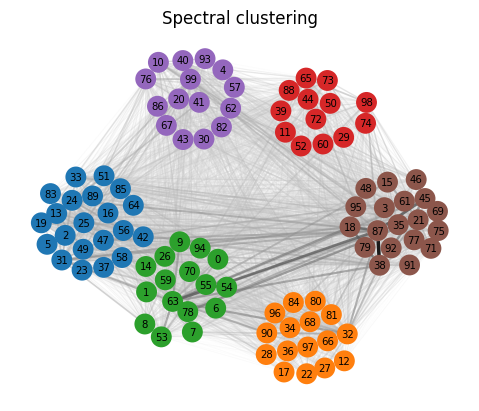

In [14]:
plot_groups(graph, best_louvain, title="Louvain algorithm")
plot_groups(graph, best_spectral, title="Spectral clustering")

## Results

[comparable coherence scores but since spectral clustering produces much more consistent clusters with less randomness than louvain we will go with the spectral clustering as our winner]

If these are in fact the narratives surrounding the murders then we could continue with trying to recover a reading sequence but now with a smaller search space. From the starting $100! \approx 10^{158}$ we now have much fewer permutations:

In [37]:
permutations = np.math.factorial(num_clusters) * np.sum(list(map(np.math.factorial, map(len, best_spectral))))
print(f"number of permutations: {permutations:.2e}")

number of permutations: 3.69e+22


This means that we have made an improvement of 136 orders of magnitude! So now we are left with the "easy" part of just reading through these narratives. 😉

## Sources

Our GitHub repository: https://github.com/maxstolly/Graph-Algorithms-Project/

- [Fast unfolding of communities in large networks](https://arxiv.org/abs/0803.0476)
- [From Louvain to Leiden: guaranteeing well-connected communities](https://arxiv.org/abs/1810.08473)
- [A Tutorial on Spectral Clustering](https://arxiv.org/abs/0711.0189)
- [On Spectral Clustering: Analysis and an Algorithm](https://proceedings.neurips.cc/paper/2001/file/801272ee79cfde7fa5960571fee36b9b-Paper.pdf)
- [A Gentle Introduction to Graph Neural Networks](https://distill.pub/2021/gnn-intro/)
- [A Gentle Introduction to Deep Learning for Graphs](https://arxiv.org/abs/1912.12693)
- [Attention, Learn to Solve Routing Problems!](https://arxiv.org/abs/1803.08475)
- [Learning the Travelling Salesperson Problem Requires Rethinking Generalization](https://arxiv.org/abs/2006.07054)